In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import imageio
import cv2
from itertools import product
import shutil
import scipy.stats as stats
# import multiprocess as mp

sys.path.append("./utils")
from myUtils import mkdir
from caUtils import plot_simulation, load_data
from Model import Model

### Script parameters
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script
jarFileName = "./HAL_fds.jar"
# nProcesses = 4 # Number of cores to use for multi-processing
# palette_sensitiveResistant = {"S":"#0F4C13", "R":"#710303"} # Red/green scheme
palette_sensitiveResistant = {"S":"#5E7FDD", "R":"#D0D645", "TumourSize":"black"}
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':600,"saveModelState":True,
                  "localFreq":0,"imageFrequency":-1,
                  "nReplicates":100,'dieProb':0.005,'pResistant':0.1,"dt":2}

dataDir = "./data/cellCountGlobalFreq"
imgDir = "./data/imagesGlobalFreq"
seedToShowImagesFor = 1
# treatmentScheduleList = [[0,10,0], [10,50,1]]

### Script parameters
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script
# jarFileName = "./code.jar"
# nProcesses = 4 # Number of cores to use for multi-processing
palette_sensitiveResistant = {"S":"#5E7FDD", "R":"#D0D645", "TumourSize":"black"}

In [2]:
myModel = Model(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
myModel.Simulate()

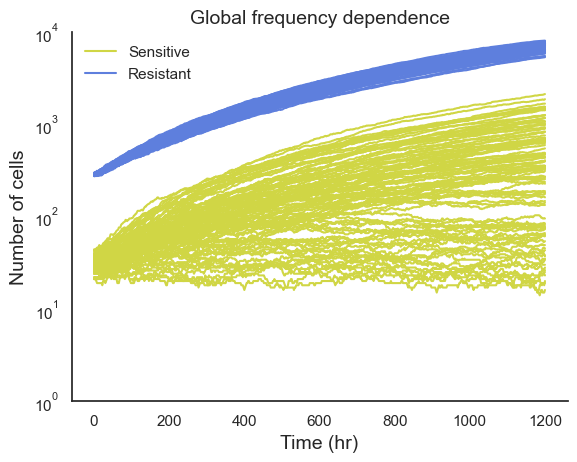

In [3]:
data_files = os.listdir(dataDir)
data_list = []

for file in data_files:
    if file.endswith(".csv"):
        data_list.append(pd.read_csv(os.path.join(dataDir, file)))

fig,ax = plt.subplots()

for df in data_list:
    ax.plot(df["Time"],df["NCells_R"],color=palette_sensitiveResistant["R"],alpha=1)
    ax.plot(df["Time"],df["NCells_S"],color=palette_sensitiveResistant["S"],alpha=1)

ax.set_yscale("log")
ax.set_xlabel('Time (hr)',fontsize=14)
ax.set_ylabel('Number of cells',fontsize=14)
ax.legend(['Sensitive', 'Resistant'],frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Global frequency dependence',fontsize=14)
ax.set_ylim(1,1e4)
data_list_global = data_list

In [4]:
# simulate local frequency dependence
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':600,"saveModelState":True,
                  "localFreq":1,"imageFrequency":-1,
                  "nReplicates":100,'dieProb':0.005,'pResistant':0.1,"dt":2}

dataDir = "./data/cellCountLocalFreq"
imgDir = "./data/imagesLocalFreq"

myModel = Model(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
myModel.Simulate()

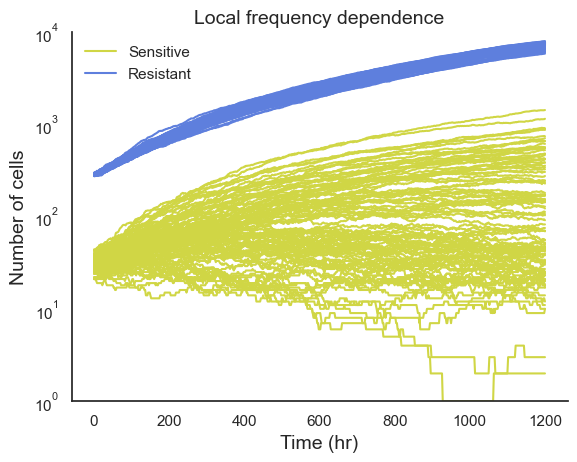

In [5]:
# load data

data_files = os.listdir(dataDir)
data_list = []

for file in data_files:
    if file.endswith(".csv"):
        data_list.append(pd.read_csv(os.path.join(dataDir, file)))

fig,ax = plt.subplots()

for df in data_list:
    ax.plot(df["Time"],df["NCells_R"],color=palette_sensitiveResistant["R"],alpha=1)
    ax.plot(df["Time"],df["NCells_S"],color=palette_sensitiveResistant["S"],alpha=1)

ax.set_yscale("log")
ax.set_xlabel('Time (hr)',fontsize=14)
ax.set_ylabel('Number of cells',fontsize=14)
ax.legend(['Sensitive', 'Resistant'],frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Local frequency dependence',fontsize=14)
ax.set_ylim(1,1e4)
data_list_local = data_list

In [6]:
# simulate no frequency dependence
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':600,"saveModelState":True,
                  "localFreq":0,"imageFrequency":-1,
                  "nReplicates":100,'dieProb':0.005,'pResistant':0.1,"dt":2,
                  'wtAlpha':0,'wtBeta':0,'resAlpha':0,'resBeta':0}

dataDir = "./data/cellCountNoFreq"
imgDir = "./data/imagesNoFreq"

myModel = Model(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
myModel.Simulate()

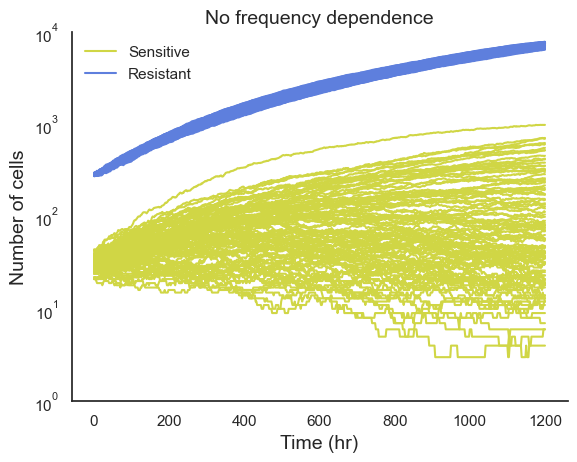

In [7]:
data_files = os.listdir(dataDir)
data_list = []

for file in data_files:
    if file.endswith(".csv"):
        data_list.append(pd.read_csv(os.path.join(dataDir, file)))

fig,ax = plt.subplots()

for df in data_list:
    ax.plot(df["Time"],df["NCells_R"],color=palette_sensitiveResistant["R"],alpha=1)
    ax.plot(df["Time"],df["NCells_S"],color=palette_sensitiveResistant["S"],alpha=1)

ax.set_yscale("log")
ax.set_xlabel('Time (hr)',fontsize=14)
ax.set_ylabel('Number of cells',fontsize=14)
ax.legend(['Sensitive', 'Resistant'],frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('No frequency dependence',fontsize=14)

ax.set_ylim(1,1e4)
data_list_no_fds = data_list

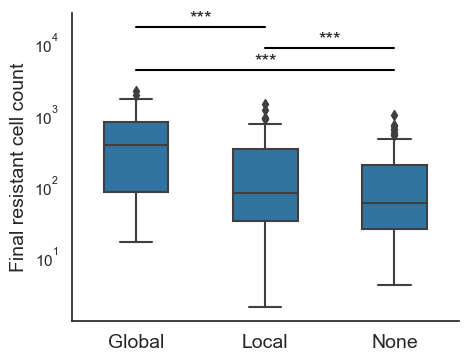

In [8]:
# now use seaborn
global_res_final = [df["NCells_R"].iloc[-1] for df in data_list_global]
local_res_final = [df["NCells_R"].iloc[-1] for df in data_list_local]
no_fds_res_final = [df["NCells_R"].iloc[-1] for df in data_list_no_fds]

fig,ax = plt.subplots(figsize=(5,4))

sns.boxplot(data=[global_res_final,local_res_final,no_fds_res_final],ax=ax,color="tab:blue",width=0.5)
ax.set_ylabel("Final resistant cell count",fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0,1,2])
ax.set_xticklabels(["Global","Local","None"],fontsize=14)
ax.set_yscale("log")

data = [global_res_final,local_res_final,no_fds_res_final]

# calculate pairwise p-values
res = stats.ttest_ind(global_res_final,local_res_final,equal_var=False)
p_val_1 = res.pvalue # global vs local
res = stats.ttest_ind(global_res_final,no_fds_res_final,equal_var=False)
p_val_2 = res.pvalue # global vs no fds
res = stats.ttest_ind(local_res_final,no_fds_res_final,equal_var=False)
p_val_3 = res.pvalue
# Add asterisks for pairwise significance (p < 0.05)
ylevel = np.max(data[0])*2

ax.plot([0, 2], [ylevel,ylevel], color='black')
yval2 = ylevel # corresponds to global vs local
ylevel = ylevel*2
ax.plot([1, 2], [ylevel,ylevel], color='black')
yval3 = ylevel
ylevel = ylevel*2
ax.plot([0, 1], [ylevel,ylevel], color='black')
yval1 = ylevel

# add significance asterisks
# pick the marker based on the p-value

star_list = ["*","**","***"]
p_list = np.array([0.05,0.01,0.001])


if p_val_1 < 0.05:
    star_indx = np.argwhere(p_val_1 < p_list)[-1][0]
    marker = star_list[star_indx]
    ax.annotate(marker,xy=(0.5, yval1*1.1),xycoords="data",fontsize=14,ha="center")
    # ax.plot(0.5, yval1*1.5, marker=marker, color='black')
if p_val_2 < 0.05:
    star_indx = np.argwhere(p_val_1 < p_list)[-1][0]
    marker = star_list[star_indx]
    ax.annotate(marker,xy=(1, yval2*1.1),xycoords="data",fontsize=14,ha="center")
    # ax.plot(1, yval2*1.5, marker=marker, color='black')
if p_val_3 < 0.05:
    star_indx = np.argwhere(p_val_1 < p_list)[-1][0]
    marker = star_list[star_indx]
    ax.annotate(marker,xy=(1.5, yval3*1.1),xycoords="data",fontsize=14,ha="center")
    # ax.plot(1.5, yval3*1.5, marker=marker, color='black')

# ax.annotate("p = %.3e" % p_val,xy=(0.25,0.15),xycoords="axes fraction",fontsize=14,ha="center")


fig.savefig('./data/figures/local_vs_global_freq_dependence_boxplot.png',dpi=300,bbox_inches='tight')

In [9]:
# run one simulation with local frequency dependence and save images
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':1000,"saveModelState":True,
                  "localFreq":1,"imageFrequency":10,
                  "nReplicates":5,'dieProb':0.005,'pResistant':0.1,"dt":2}

dataDir = "./data/cellCountLocalFreq"
imgDir = "./data/imagesLocalFreq"

myModel = Model(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
myModel.Simulate()

In [10]:
# run one simulation with global frequency dependence and save images
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':1000,"saveModelState":True,
                  "localFreq":0,"imageFrequency":10,
                  "nReplicates":5,'dieProb':0.005,'pResistant':0.1,"dt":2}

dataDir = "./data/cellCountGlobalFreq"
imgDir = "./data/imagesGlobalFreq"

myModel = Model(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
myModel.Simulate()

In [4]:
# run one simulation with no frequency dependence and save images
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':1000,"saveModelState":True,
                  "localFreq":0,"imageFrequency":10,
                  "nReplicates":1,'dieProb':0.005,'pResistant':0.1,"dt":2,
                  'wtAlpha':0,'wtBeta':0,'resAlpha':0,'resBeta':0}

dataDir = "./data/cellCountNoFreq"
imgDir = "./data/imagesNoFreq"

myModel = Model(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
myModel.Simulate()